 # Opis notatnika
 Zmierzamy do końca analizy danych, które zostały nam udostępnione. Ten krok dodaje jeszcze więcej informacji do naszego wyjściowego zbioru. Tym razem sprawdzimy między innymi to, czy opóźnienia lotów zależne są od trasy czy warunków pogodowych.

 Zanim jednak do tego przejdziemy, należy, podobnie jak w poprzednich krokach, skonfigurować odpowiednio notatnik.

 Tutaj zaimportuj wymagane biblioteki

In [1]:
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import sys
sys.path.append('../')

pd.set_option("display.max_colwidth", 3000)
pd.set_option("display.max_columns", None)

%matplotlib inline

 ## Połączenie z bazą danych
 Tutaj uzupełnij konfigurację połączenia

In [2]:
from config.DB_connect import username, passwd, hostname, db_name, port

 Tutaj stwórz zmienną engine, która zostanie użyta do połączenia z bazą danych

In [3]:
url = f"postgresql://{username}:{passwd}@{hostname}:{port}/{db_name}"
engine = create_engine(url, echo=False)

 Tutaj uzupełnij implementację metody `read_sql_table`

In [4]:
def read_sql_table(table_name):
    return pd.read_sql(f"SELECT * FROM {table_name}", engine)

 Tutaj zaczytaj zapisaną wcześniej ramkę danych `flight_df` do zmniennej o takiej samej nazwie

In [5]:
flight_df = pd.read_csv("../data/processed/flight_02.csv", index_col=None)

 # Wzbogacenie o `airport_list`
 Wczytaj do obszaru roboczego tabelę `airport_list` używając procedury `read_sql_table`. Wykonaj poniższe ćwiczenia:
 1. Sprawdź, czy klucz `origin_airport_id` jest unikalny, tj. nie ma dwóch takich samych wartości w kolumnie `origin_airport_id`,
 1. Jeżeli duplikaty występują, usuń je w najdogodniejszy dla Ciebie sposób.
 1. Jeśli duplikaty nie występują, złącz ramki `airport_list_df` wraz z aktualną `flight_df`, używając kolumny `origin_airport_id` oraz złączenia typu `LEFT JOIN`. Z ramki `airport_list_df` interesuje nas dodanie kolumny `origin_city_name`.
 1. Dodatkowo dokonaj jeszcze raz złączenia ramki `flight_df` z `airport_list_df`, tym razem jednak złącz kolumnę `destination_airport_id` wraz z `origin_airport_id`. Podobnie jak wcześniej, interesuje nas kolumna `origin_city_name`, jedank ona powinna zostać wyświetlona jako `destination_city_name`

 Tutaj wczytaj ramkę `airport_list_df`

In [6]:
airport_list_df = read_sql_table("airport_list")

airport_list_df.rename(
    columns={
        "name": "origin_name",
        "display_airport_name": "origin_airport_name"
    },
    inplace=True,
)

 Tutaj sprawdż, czy występują duplikaty dla kolumny `origin_airport_id`

In [7]:
airport_list_df[airport_list_df["origin_airport_id"].duplicated()]

,id,origin_airport_id,origin_airport_name,origin_city_name,origin_name


In [8]:
airport_list_df.drop(columns=["id"], inplace=True)

 Tutaj usuń duplikaty - jeśli występują

'origin_airport_id' nie zawiera duplikatów

 Tutaj dokonaj złączenia ramki `flight_df` oraz `airport_list_df` używając `origin_airport_id`

In [9]:
flight_df = flight_df.merge(
    airport_list_df,
    how="left",
    on="origin_airport_id"
)

 Tutaj dokonaj złączenia ramki `flight_df` oraz `airport_list_df` używając `destination_airport_id`

In [10]:
airport_list_df.rename(
    columns={
        "origin_airport_id": "dest_airport_id",
        "origin_airport_name": "destination_airport_name",
        "origin_city_name": "destination_city_name",
        "origin_name": "destination_name",
    },
    inplace=True,
)

In [11]:
flight_df = flight_df.merge(
    airport_list_df,
    how="left",
    on="dest_airport_id",
)

### Sprawdzenie
Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [12]:
assert (
    "origin_city_name" in flight_df.columns
), "Brak kolumny `origin_city_name` w ramce flight_df"
assert (
    "destination_city_name" in flight_df.columns
), "Brak kolumny `destination_city_name` w ramce flight_df"

flight_df_expected_rows_amount = 6922924
assert (
    flight_df.shape[0] == flight_df_expected_rows_amount
), "Ups, zwiększyła się liczba wierszy..."

 ## Analiza według lotnisk oraz tras
 Wykonaj poniższe polecenia:
 1. Wyznacz lotniska, z których **odlatywało** najwięcej samolotów. Wynik zapisz do ramki `top_airports_origin_df`.
 1. Wyznacz lotnika, na których najwięcej lotów **się kończyło**. Wynik zapisz do ramki `top_airports_destination_df`.
 1. Wyznacz najczęściej uczęszczaną trasę, wynik zapisz do ramki `top_route_df`.
 1. Przy założeniu, że reprezentatywna liczba lotów na trasie wynosi ponad 500, wyznacz dodatkowo top 10:
     - tras z **najmniejszym odsetkiem opóźnień**, wynik zapisz do ramki `least_route_delays_df`.
     - tras z **największym odsetkiem opóźnień**, wynik zapisz do ramki `top_route_delays_df`.

 Tutaj wyznacz ramkę `top_airports_origin_df`

In [13]:
top_airports_origin_df = flight_df.groupby(
    "origin_airport_id", as_index=None).count()['id']

 Tutaj wyznacz ramkę `top_airports_destination_df`

In [14]:
top_airports_destination_df = flight_df.groupby(
    "dest_airport_id", as_index=None).count()['id']

 ### Sprawdzenie dla `top_airport_origin`

In [15]:
top_airports_origin_head = (
    top_airports_origin_df.sort_values(ascending=False).head().to_list()
)
top_airports_origin_head = tuple(top_airports_origin_head)
top_airports_origin_head_expected = (387620, 327647, 294944, 245160, 228415)

assert (
    top_airports_origin_head == top_airports_origin_head_expected
), f"Nie zgadza się top 5 wierszy, oczekiwano wyników: {top_airports_origin_head_expected} otrzymano: {top_airports_origin_head}"

### Sprawdzenie dla `top_airport_destination`

In [16]:
top_airports_destination_head = (
    top_airports_destination_df.sort_values(ascending=False).head().to_list()
)
top_airports_destination_head = tuple(top_airports_destination_head)
top_airports_destination_head_expected = (
    387542, 327169, 294568, 244898, 227917)

assert (
    top_airports_destination_head == top_airports_destination_head_expected
), f"Nie zgadza się top 5 wierszy, oczekiwano wyników: {top_airports_destination_head_expected} otrzymano: {top_airports_destination_head}"

 1. Wyznacz najczęściej uczęszczaną trasę, wynik zapisz do ramki `top_route_df`.


In [17]:
top_route_df = flight_df.groupby(
    ['origin_airport_id', 'dest_airport_id'], as_index=None)['id'].agg('count')
top_route_df.rename(columns={'id': 'route_count'}, inplace=True)
top_route_df.sort_values(by=['route_count'], inplace=True, ascending=False)

 1. Przy założeniu, że reprezentatywna liczba lotów na trasie wynosi ponad 500, wyznacz dodatkowo top 10:
     - tras z **najmniejszym odsetkiem opóźnień**, wynik zapisz do ramki `least_route_delays_df`.
     - tras z **największym odsetkiem opóźnień**, wynik zapisz do ramki `top_route_delays_df`.

In [18]:
# dodawanie informacji o ilości lotów do flight_df

flight_df = pd.merge(
    left=flight_df,
    right=top_route_df,
    on=['origin_airport_id', 'dest_airport_id']
)
flight_df.sort_values(by=['route_count'], inplace=True, ascending=False)

flight_df.shape[0]

6922924

In [19]:
least_route_delays_df = flight_df.loc[flight_df['route_count'] > 500].sort_values(
    by=['dep_delay'], ascending=True)
least_route_delays_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,dep_time_blk,crs_arr_time,arr_time,arr_delay_new,arr_time_blk,cancelled,crs_elapsed_time,actual_elapsed_time,distance,distance_group,year,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_airport_name,origin_city_name,origin_name,destination_airport_name,destination_city_name,destination_name,route_count
1031860,1315543,2,16,6,OO,N176SY,3321,11259,12892,800,755.0,0.0,0800-0859,940,1014.0,34.0,0900-0959,0,220.0,259.0,1246,5,2019,0.0,0.0,34.0,0.0,0.0,False,True,"(1200, 1300]",2016.0,"(2014, 2017]",Dallas Love Field,"Dallas, TX","DALLAS FAA AIRPORT, TX US",Los Angeles International,"Los Angeles, CA","LOS ANGELES INTERNATIONAL AIRPORT, CA US",2664
3559754,4704355,1,7,1,YX,N427YX,4546,12953,14027,900,853.0,0.0,0900-0959,1223,1147.0,0.0,1200-1259,0,203.0,174.0,1035,5,2019,NaN,NaN,NaN,NaN,NaN,False,False,"(1000, 1100]",2014.0,"(2011, 2014]",LaGuardia,"New York, NY","LAGUARDIA AIRPORT, NY US",Palm Beach International,"West Palm Beach/Palm Beach, FL","WEST PALM BEACH INTERNATIONAL AIRPORT, FL US",2664
3696717,4845994,10,31,4,DL,N325US,2112,12953,14027,1245,1245.0,0.0,1200-1259,1538,1549.0,11.0,1500-1559,0,173.0,184.0,1035,5,2019,NaN,NaN,NaN,NaN,NaN,False,False,"(1000, 1100]",1991.0,"(1990, 1993]",LaGuardia,"New York, NY","LAGUARDIA AIRPORT, NY US",Palm Beach International,"West Palm Beach/Palm Beach, FL","WEST PALM BEACH INTERNATIONAL AIRPORT, FL US",2664
3558806,4703406,1,5,6,B6,N706JB,461,12953,14027,730,724.0,0.0,0700-0759,1038,1033.0,0.0,1000-1059,0,188.0,189.0,1035,5,2019,NaN,NaN,NaN,NaN,NaN,False,True,"(1000, 1100]",2008.0,"(2005, 2008]",LaGuardia,"New York, NY","LAGUARDIA AIRPORT, NY US",Palm Beach International,"West Palm Beach/Palm Beach, FL","WEST PALM BEACH INTERNATIONAL AIRPORT, FL US",2664
1054172,1339231,6,13,4,OO,N185SY,3323,11259,12892,1255,1246.0,0.0,1200-1259,1410,1401.0,0.0,1400-1459,0,195.0,195.0,1246,5,2019,NaN,NaN,NaN,NaN,NaN,False,False,"(1200, 1300]",2016.0,"(2014, 2017]",Dallas Love Field,"Dallas, TX","DALLAS FAA AIRPORT, TX US",Los Angeles International,"Los Angeles, CA","LOS ANGELES INTERNATIONAL AIRPORT, CA US",2664


In [20]:
least_route_delays_df.shape[0]

6463719

In [21]:
top_route_delays_df = flight_df.loc[flight_df['route_count'] > 500].sort_values(
    by=['dep_delay'], ascending=False)
top_route_delays_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,dep_time_blk,crs_arr_time,arr_time,arr_delay_new,arr_time_blk,cancelled,crs_elapsed_time,actual_elapsed_time,distance,distance_group,year,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_airport_name,origin_city_name,origin_name,destination_airport_name,destination_city_name,destination_name,route_count
109369,135265,12,12,4,OO,N727SK,3253,15096,13930,1511,1221.0,2710.0,1500-1559,1632,1327.0,2695.0,1600-1659,0,141.0,126.0,607,3,2019,2695.0,0.0,0.0,0.0,0.0,True,False,"(600, 700]",2005.0,"(2002, 2005]",Syracuse Hancock International,"Syracuse, NY","SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US",Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",2673
4518689,6039058,2,17,7,MQ,N817AE,3888,11433,12953,1728,1400.0,2672.0,1700-1759,1922,1531.0,2649.0,1900-1959,0,114.0,91.0,502,3,2019,2592.0,0.0,0.0,0.0,57.0,True,True,"(500, 600]",2002.0,"(1999, 2002]",Detroit Metro Wayne County,"Detroit, MI","DETROIT METRO AIRPORT, MI US",LaGuardia,"New York, NY","LAGUARDIA AIRPORT, NY US",4893
1008667,1287738,2,8,5,YV,N922FJ,5813,14698,14107,615,1904.0,2209.0,0600-0659,851,2137.0,2206.0,0800-0859,0,96.0,93.0,509,3,2019,0.0,0.0,0.0,0.0,2206.0,True,False,"(500, 600]",2004.0,"(2002, 2005]",NaN,NaN,NaN,Phoenix Sky Harbor International,"Phoenix, AZ","PHOENIX AIRPORT, AZ US",1404
598600,758565,4,12,5,MQ,N678AE,3654,11637,13930,540,1619.0,2079.0,0001-0559,739,1814.0,2075.0,0700-0759,0,119.0,115.0,557,3,2019,0.0,61.0,0.0,0.0,2014.0,True,False,"(500, 600]",2004.0,"(2002, 2005]",NaN,NaN,NaN,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1346
5320495,7118140,2,7,4,MQ,N663AR,3879,15048,13930,551,1615.0,2064.0,0001-0559,734,1744.0,2050.0,0700-0759,0,103.0,89.0,436,2,2019,968.0,0.0,0.0,0.0,1082.0,True,False,"(400, 500]",2004.0,"(2002, 2005]",NaN,NaN,NaN,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",924


In [22]:
top_route_delays_df.shape[0]

6463719

 # Wzbogacenie o dane pogodowe
 Używając procedury `read_sql_table`, wczytaj tabelę `airport_weather` do ramki `airport_weather_df`. Następnie wykonaj następujące polecenia:
 1. Pozostaw w ramce tylko następujące kolumny: `['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']`.
 1. Połącz ramki `airport_list_df` wraz z `airport_weather_df` po odpowiedniej kolumnie używając takiego złączenia, aby w wyniku usunąć te wiersze (lotniska), które nie posiadają danych pogodowych. Dodatkowo, upewnij się, że zostanie tylko dodana kolumna `origin_airport_id`.

 Tutaj wczytaj ramkę `airport_weather`

In [23]:
airport_weather_df = read_sql_table("airport_weather")
airport_weather_df.columns

Index(['id', 'wt18', 'station', 'name', 'date', 'awnd', 'prcp', 'snow', 'snwd',
       'tavg', 'tmax', 'tmin', 'wdf2', 'wdf5', 'wsf2', 'wsf5', 'wt01', 'wt08',
       'wt02', 'wt03', 'wt04', 'wt09', 'wt06', 'wt05', 'pgtm', 'wt10', 'wesd',
       'sn32', 'sx32', 'psun', 'tsun', 'tobs', 'wt07', 'wt11'],
      dtype='object')

 Tutaj oczyść ramkę `airport_weather_df` z nadmiarowych kolumn

In [24]:
airport_weather_df.drop(
    columns=[
        "id",
        "wt18",
        "tavg",
        "tmin",
        "wdf2",
        "wdf5",
        "wsf2",
        "wsf5",
        "wt01",
        "wt08",
        "wt02",
        "wt03",
        "wt04",
        "wt09",
        "wt06",
        "wt05",
        "pgtm",
        "wt10",
        "wesd",
        "sn32",
        "sx32",
        "psun",
        "tsun",
        "tobs",
        "wt07",
        "wt11",
    ],
    inplace=True,
)

In [25]:
airport_weather_df.columns

Index(['station', 'name', 'date', 'awnd', 'prcp', 'snow', 'snwd', 'tmax'], dtype='object')

In [26]:
airport_list_df.columns

Index(['dest_airport_id', 'destination_airport_name', 'destination_city_name',
       'destination_name'],
      dtype='object')

 Tutaj połącz ramki `airport_list_df` oraz `airport_weather_df` aktualizując `airport_weather_df`

In [27]:
airport_weather_df = pd.merge(
    left=airport_list_df,
    right=airport_weather_df,
    left_on="destination_name",
    right_on="name",
)
airport_weather_df

,dest_airport_id,destination_airport_name,destination_city_name,destination_name,station,name,date,awnd,prcp,snow,snwd,tmax
0,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,"FRESNO YOSEMITE INTERNATIONAL, CA US",2019-01-01,3.13,0.00,0.0,0.0,50.0
1,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,"FRESNO YOSEMITE INTERNATIONAL, CA US",2019-01-02,1.12,0.00,0.0,0.0,55.0
2,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,"FRESNO YOSEMITE INTERNATIONAL, CA US",2019-01-03,2.01,0.00,0.0,0.0,59.0
3,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,"FRESNO YOSEMITE INTERNATIONAL, CA US",2019-01-04,2.68,0.00,0.0,0.0,64.0
4,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US",USW00093193,"FRESNO YOSEMITE INTERNATIONAL, CA US",2019-01-05,7.38,0.30,0.0,0.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43389,10693,Myrtle Beach International,"Myrtle Beach, SC","NORTH MYRTLE BEACH, SC US",USW00093718,"NORTH MYRTLE BEACH, SC US",2020-03-27,12.30,0.00,NaN,NaN,75.0
43390,10693,Myrtle Beach International,"Myrtle Beach, SC","NORTH MYRTLE BEACH, SC US",USW00093718,"NORTH MYRTLE BEACH, SC US",2020-03-28,13.87,0.00,NaN,NaN,77.0
43391,10693,Myrtle Beach International,"Myrtle Beach, SC","NORTH MYRTLE BEACH, SC US",USW00093718,"NORTH MYRTLE BEACH, SC US",2020-03-29,13.87,0.00,NaN,NaN,80.0
43392,10693,Myrtle Beach International,"Myrtle Beach, SC","NORTH MYRTLE BEACH, SC US",USW00093718,"NORTH MYRTLE BEACH, SC US",2020-03-30,5.82,0.00,NaN,NaN,80.0


 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [28]:
airport_weather_df_expected_shape = (43394, 12)
airport_weather_df_shape = airport_weather_df.shape

assert (
    airport_weather_df_expected_shape == airport_weather_df_shape
), f"Nieodpowiedni wymiar ramki airport_weather_df, oczekiwano (wierszy, kolumn): {airport_weather_df_expected_shape}"

 ## Połączenie `airport_weather_df` oraz `flight_df`
 W celu złączenia ramek `airport_weather_df` oraz `flight_df` wykonaj następujące kroki:
 1. w ramce `aiport_weather_df` występuje kolumna `date`, zrzutuj ją na typ `DATETIME`.
 1. w ramce `flight_df` należy stworzyć nową kolumnę o nazwie `date`. W tym celu:
 	- złącz kolumny `month`, `day_of_month` oraz `year` razem, użyj następującego formatu daty: `YYYY-MM-DD`.
 	- zrzutuj kolumnę `date` na typ `DATETIME`.
 1. złącz ramki używając odpowiedniego klucza, wynik złączenia zapisz do ramki `flight_df`. Uzyj złącznia typu `LEFT JOIN`.

 > Dlaczego istotne jest zachowanie typów przy złączeniu?

W trakcie pracy możesz posłużyć się następującymi artykułami z `LMS`:
 - `Python - analiza danych > Dzień 6 - Pandas > Merge`
 - `Python - analiza danych > Dzień 6 - Pandas > Praca z datetime`
 - Dokumentacje metody `to_datetime`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)
 - Dostępne formaty dat: [klik](https://www.programiz.com/python-programming/datetime/strftime) - sekcja `Format Code List`

 Tutaj zrzutuj kolumnę `date` na `DATETIME` w ramce `airport_weather_df`

In [29]:
airport_weather_df["date"] = pd.to_datetime(airport_weather_df["date"])
airport_weather_df['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 43394 entries, 0 to 43393
Series name: date
Non-Null Count  Dtype         
--------------  -----         
43394 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 339.1 KB


 Tutaj stwórz kolumnę `date` w ramce `flight_df`. Pamiętaj, aby była ona również typu `DATETIME`

In [30]:
flight_df['date'] = pd.to_datetime(
    dict(year=flight_df.year, month=flight_df.month, day=flight_df.day_of_month))
flight_df['date'].info()

<class 'pandas.core.series.Series'>
Index: 6922924 entries, 6307175 to 1249465
Series name: date
Non-Null Count    Dtype         
--------------    -----         
6922924 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 105.6 MB


In [31]:
flight_df.columns

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'year', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'is_delayed', 'is_weekend', 'distance_agg',
       'manufacture_year', 'manufacture_year_agg', 'origin_airport_name',
       'origin_city_name', 'origin_name', 'destination_airport_name',
       'destination_city_name', 'destination_name', 'route_count', 'date'],
      dtype='object')

In [32]:
airport_weather_df.columns

Index(['dest_airport_id', 'destination_airport_name', 'destination_city_name',
       'destination_name', 'station', 'name', 'date', 'awnd', 'prcp', 'snow',
       'snwd', 'tmax'],
      dtype='object')

In [33]:
airport_weather_df.drop(columns=["name"], inplace=True)

 Tutaj złącz tabele `airport_weather_df` oraz `flight_df`

In [34]:
flight_df = flight_df.merge(airport_weather_df, how='left', on=['date',
                                                                'dest_airport_id',
                                                                'destination_airport_name',
                                                                'destination_city_name',
                                                                'destination_name'],
                            )

In [35]:
flight_df.columns

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'year', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'is_delayed', 'is_weekend', 'distance_agg',
       'manufacture_year', 'manufacture_year_agg', 'origin_airport_name',
       'origin_city_name', 'origin_name', 'destination_airport_name',
       'destination_city_name', 'destination_name', 'route_count', 'date',
       'station', 'awnd', 'prcp', 'snow', 'snwd', 'tmax'],
      dtype='object')

In [36]:
airport_weather_df.rename(
    columns={
        "dest_airport_id": "origin_airport_id",
        "destination_airport_name": "origin_airport_name",
        "destination_city_name": "origin_city_name",
        "destination_name": "origin_name",
    },
    inplace=True,
)

In [37]:
airport_weather_df.columns

Index(['origin_airport_id', 'origin_airport_name', 'origin_city_name',
       'origin_name', 'station', 'date', 'awnd', 'prcp', 'snow', 'snwd',
       'tmax'],
      dtype='object')

In [38]:
flight_df = flight_df.merge(airport_weather_df,
                            how='left',
                            on=["date", "origin_airport_id",
                                "origin_airport_name",
                                "origin_city_name",
                                "origin_name",
                                ],
                            suffixes=("_dest", "_origin"),
                            )

In [39]:
flight_df.columns

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'year', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'is_delayed', 'is_weekend', 'distance_agg',
       'manufacture_year', 'manufacture_year_agg', 'origin_airport_name',
       'origin_city_name', 'origin_name', 'destination_airport_name',
       'destination_city_name', 'destination_name', 'route_count', 'date',
       'station_dest', 'awnd_dest', 'prcp_dest', 'snow_dest', 'snwd_dest',
       'tmax_dest', 'station_origin', 'awnd_origin', 'prcp_origin',
       'snow_origin', 'snwd_origin', 'tmax_origin'],
      dtype='object')

 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [40]:
flight_df_expected_rows_amount = 6922924
assert (
    flight_df.shape[0] == flight_df_expected_rows_amount
), "Ups, zmieniła się liczba wierszy..."

 # Praca samodzielna
 Używając `flight_df` zbadaj następujące hipotezy:
 1. Opady śniegu w lotnisku wylotowym wpływają na **wielkość** opóźnienia lotów (kolumna `snow`).
 1. Wielkość pokrywy śnieżnej wpływa na **wielkość** opóźnienia lotów (kolumna `snwd`).
 1. Temperatura maksymalna wpływa na **wielkość** opóźnienia lotów (kolumna `tmax`).
 W każdym ćwiczeniu pamiętaj o uwzględnieniu tylko tych zjawisk atmosferycznych, które były zaobserwowane (`>`). Przy wykonywaniu tego zadania masz pełną dowolność.

> **Wskazówka:**  
> Pamiętaj o tym, aby każda analiza była porównywalna, tj. dokonana przy podobnych założeniach.

 ## Analiza dla kolumny `snow`

 ### Określenie statystyk opisowych dla kolumny `snow`

In [41]:
flight_df_snow = flight_df.loc[flight_df['snow_origin'] > 0][[
    'dep_delay', 'snow_origin']]

In [42]:
# flight_df_snow.corr().style.background_gradient(cmap='seismic')

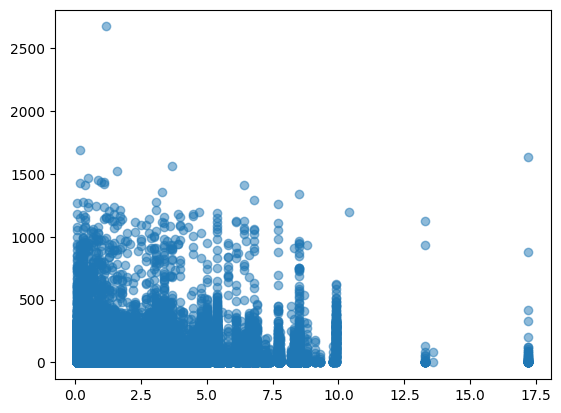

In [43]:
plt.scatter(flight_df_snow.snow_origin, flight_df_snow.dep_delay, alpha=0.5)
plt.xlabel = "ilość opadów śniegu"
plt.ylabel = "czas opóżnienia odlotów"
plt.show()

 ## Analiza dla kolumny `snwd`

 ### Określenie statystyk opisowych dla kolumny `snwd`

In [44]:
flight_df_snwd = flight_df.loc[flight_df['snwd_origin'] > 0][[
    'dep_delay', 'snwd_origin']]
# flight_df_snwd.corr().style.background_gradient(cmap='seismic')

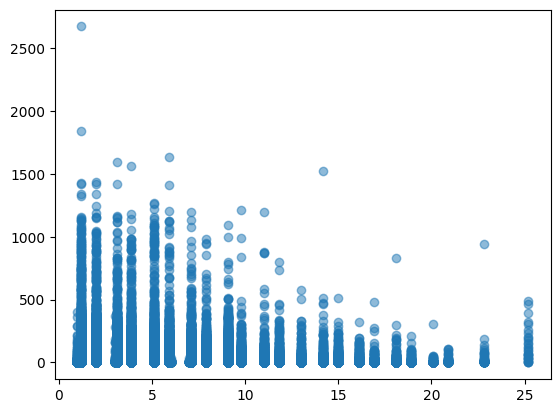

In [45]:
plt.scatter(flight_df_snwd.snwd_origin, flight_df_snwd.dep_delay, alpha=0.5)
plt.xlabel = "grubość zalegającego śniegu"
plt.ylabel = "czas opóżnienia odlotów"
plt.show()

 ## Analiza dla kolumny `tmax`

 ### Określenie statystyk opisowych dla kolumny `tmax`

In [46]:
flight_df_tmax = flight_df[['dep_delay', 'tmax_origin']]
# flight_df_tmax.corr().style.background_gradient(cmap='seismic')

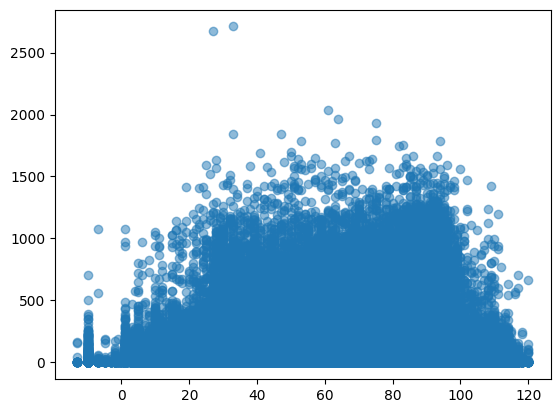

In [47]:
plt.scatter(flight_df_tmax.tmax_origin, flight_df_tmax.dep_delay, alpha=0.5)
plt.xlabel = "temperatura"
plt.ylabel = "czas opóżnienia odlotów"
plt.show()

# Podsumowanie
W tej części warsztatu dokonaliśmy kompleksowej analizy posiadanego zbioru danych. Eksploracja
pozwoliła nam na zapoznanie się z cechami charakterystycznymi lotów - wiemy już, które 
zmienne mogą mieć wpływ na opóźnienia lotów, a które nie. Co warto podkreślić, skupiliśmy się na wielu
aspektach tej analizy, co otwiera potencjalnie również inne możliwości dalszej pracy nad tą bazą.

W tym momencie przejdziemy do kolejnego kroku, w którym, na podstawie tej analizy, przygotujemy 
system raportowy. Zanim jednak stworzymy dashboard, potrzebujemy zaktualizować naszą bazę danych.